Epoch 1/20


C:\Users\estef\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3227/3227 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8517 - loss: 0.4565 - val_accuracy: 0.9488 - val_loss: 0.1306
Epoch 2/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9525 - loss: 0.1125 - val_accuracy: 0.9665 - val_loss: 0.0790
Epoch 3/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9742 - loss: 0.0707 - val_accuracy: 0.9811 - val_loss: 0.0524
Epoch 4/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9786 - loss: 0.0544 - val_accuracy: 0.9843 - val_loss: 0.0454
Epoch 5/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9811 - loss: 0.0474 - val_accuracy: 0.9869 - val_loss: 0.0380
Epoch 6/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9818 - loss: 0.0452 - val_accuracy: 0.9831 - val_loss: 0.0397
Epoch 7/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9836 - loss: 0.0400 - val_accuracy: 0.9847 - val_loss: 0.0359
Epoch 8/20
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9835 - loss: 0.0395 - val_accur

1383/1383 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy en el conjunto de prueba: 0.99


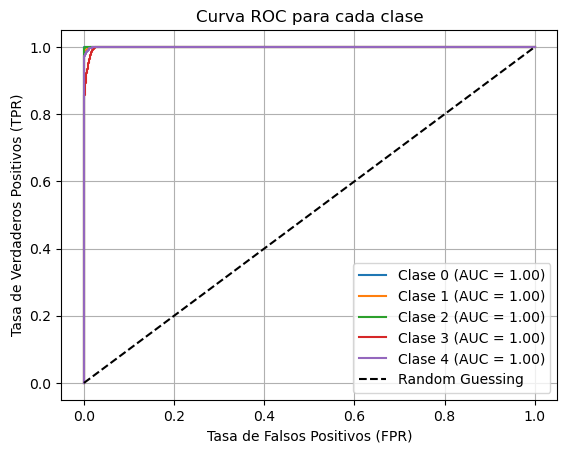

3227/3227 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


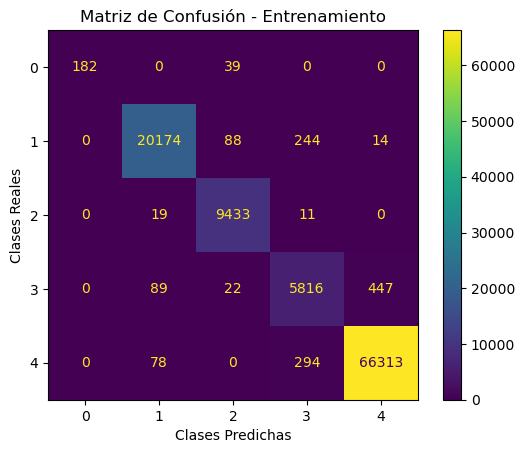

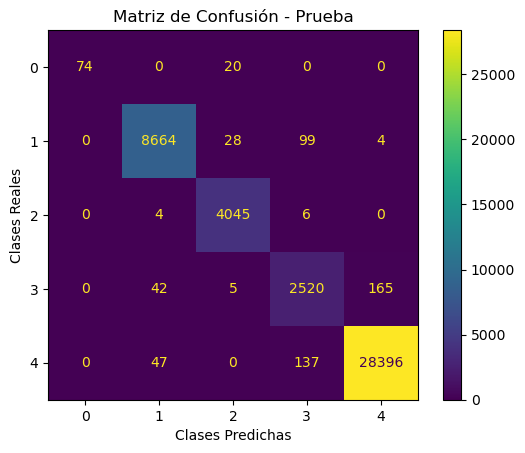

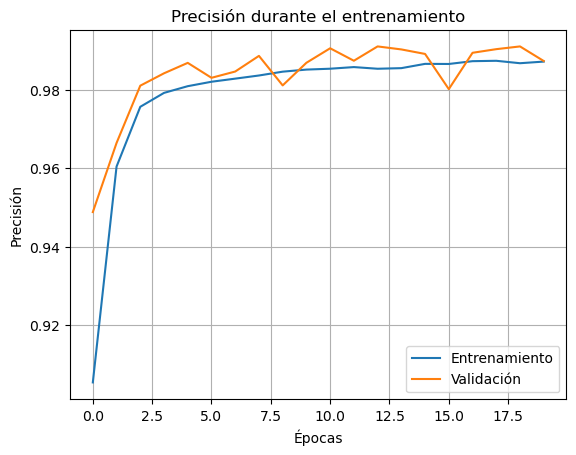

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Clase de partícula predicha: [0]


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from kafka import KafkaProducer
import json
import joblib

# Cargar el dataset
data = pd.read_csv('PPC.csv')

# Filtrar datos dentro del rango deseado en las columnas 'TPC' y 'Momento'
filtered_data = data[(data['TPC'] >= 0) & (data['TPC'] <= 700) & (data['Momento'] >= 0) & (data['Momento'] <= 5)]

# Seleccionar las columnas relevantes (TPC y Momento) después del filtrado
X = filtered_data[['Momento', 'TPC']].values
y = filtered_data['Clase'].values  # Suponiendo que 'Clase' contiene las etiquetas

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')

# One-hot encode de las etiquetas
num_classes = len(np.unique(y))
y_encoded = to_categorical(y, num_classes=num_classes)

# Dividir los datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y)

# Construir el modelo de red neuronal
model = Sequential([
    Dense(64, input_dim=X_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')  # Número de clases como salida
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Guardar el modelo entrenado
model.save('modelo_entrenado.h5')

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Gráfica de ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred = model.predict(X_test).argmax(axis=1)

# Clases reales en los conjuntos de entrenamiento y prueba
y_train_true = y_train.argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

#Confussion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='viridis', values_format='d')
    plt.title(title)
    plt.xlabel("Clases Predichas")
    plt.ylabel("Clases Reales")
    plt.grid(False)
    plt.show()

# Graficar matrices
plot_confusion_matrix(y_train_true, y_train_pred, "Matriz de Confusión - Entrenamiento")
plot_confusion_matrix(y_test_true, y_test_pred, "Matriz de Confusión - Prueba")

# Gráfica de la precisión a lo largo de las épocas
plt.figure()
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

# Configurar Kafka Producer
producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))

# Función para enviar datos a Kafka
def send_to_kafka(particle_data):
    producer.send('particle_data', particle_data)

# Ejemplo de envío de datos
example_data = {'Momento': 1.2, 'TPC': 300}
send_to_kafka(example_data)

# Función para predecir el tipo de partícula a partir de nuevos datos
def predict_particle(data):
    scaler = joblib.load('scaler.pkl')  # Cargar el scaler
    data_scaled = scaler.transform([data])
    prediction = model.predict(data_scaled)
    predicted_class = prediction.argmax(axis=1)
    return predicted_class

# Ejemplo de predicción con nuevos datos
new_data = [1.2, 500]  # Ejemplo de nuevos datos
predicted_particle = predict_particle(new_data)
print(f"Clase de partícula predicha: {predicted_particle}")


In [11]:
# Cargar el dataset original
data = pd.read_csv('PPC.csv')

# Filtrar datos dentro del rango deseado en las columnas 'TPC' y 'Momento'
filtered_data = data[(data['TPC'] >= 0) & (data['TPC'] <= 700) & (data['Momento'] >= 0) & (data['Momento'] <= 5)]

# Seleccionar las columnas relevantes (TPC y Momento) después del filtrado
X = filtered_data[['Momento', 'TPC']].values

# Cargar el scaler previamente guardado
scaler = joblib.load('scaler.pkl')

# Normalizar los datos
X_scaled = scaler.transform(X)

# Cargar el modelo previamente entrenado
from tensorflow.keras.models import load_model
model = load_model('modelo_entrenado.h5')

# Predecir las clases para todos los datos en el dataset filtrado
predictions = model.predict(X_scaled)
predicted_classes = predictions.argmax(axis=1)  # Obtener las clases predichas

# Agregar las clases predichas como una nueva columna al DataFrame original filtrado
filtered_data['Clase_Predicha'] = predicted_classes

# Guardar el dataset con la nueva columna en un archivo CSV
filtered_data.to_csv('PPC_con_Clase_Predicha.csv', index=False)

print("El dataset con la columna de clases predichas ha sido guardado como 'PPC_con_Clase_Predicha.csv'.")


4610/4610 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


C:\Users\estef\AppData\Local\Temp\ipykernel_24544\4075181623.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Clase_Predicha'] = predicted_classes


El dataset con la columna de clases predichas ha sido guardado como 'PPC_con_Clase_Predicha.csv'.


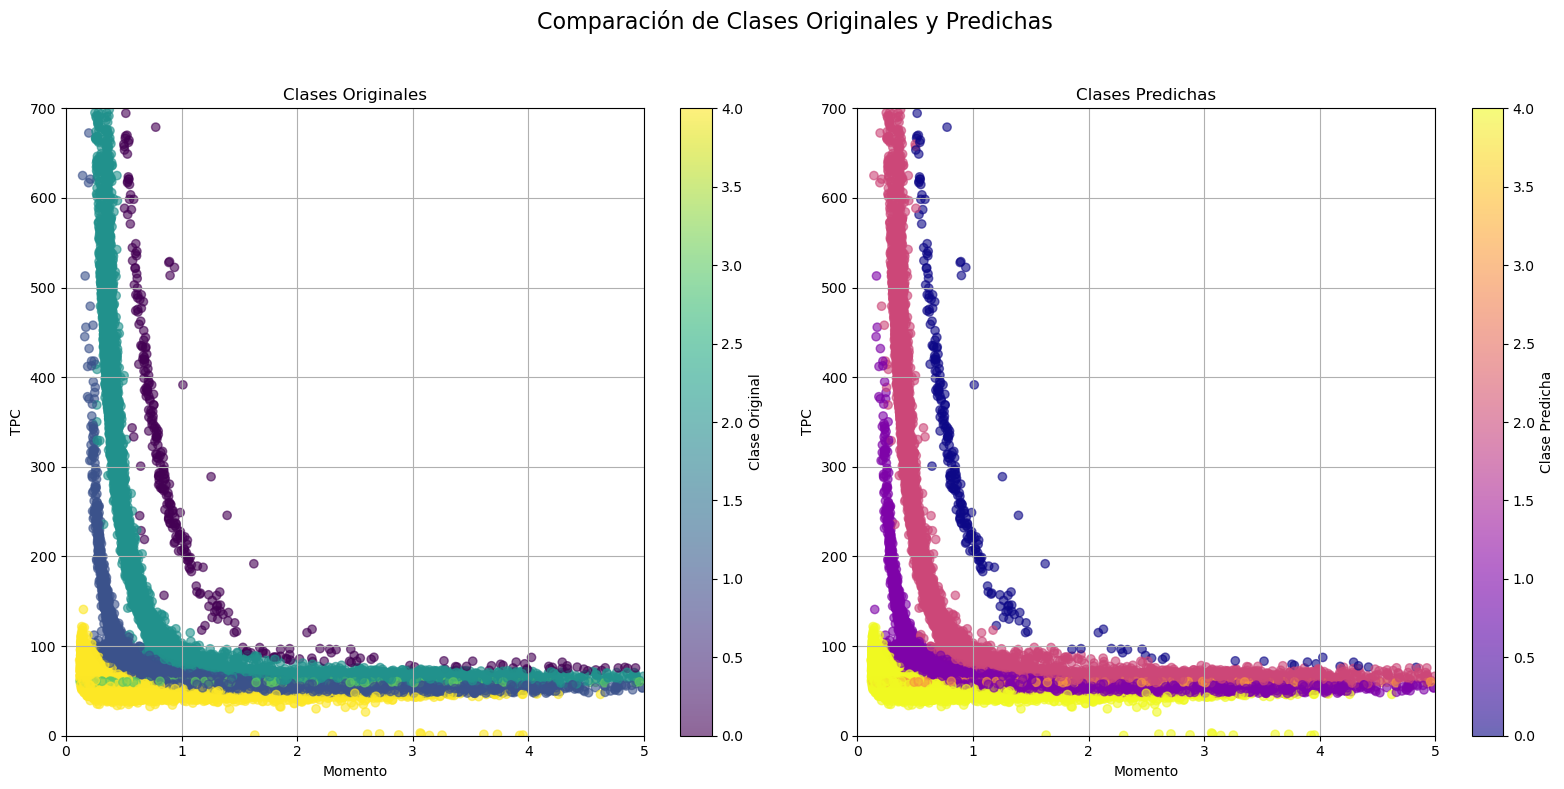

In [13]:
import matplotlib.pyplot as plt

# Cargar el dataset con las clases predichas
data = pd.read_csv('PPC_con_Clase_Predicha.csv')

# Crear una figura con dos subgráficos para comparar
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: Clases originales
scatter1 = axes[0].scatter(
    data['Momento'],
    data['TPC'],
    c=data['Clase'],  # Color por clase original
    cmap='viridis',
    alpha=0.6
)
axes[0].set_title('Clases Originales')
axes[0].set_xlabel('Momento')
axes[0].set_ylabel('TPC')
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 700)
axes[0].grid(True)

# Agregar barra de colores para el primer gráfico
cbar1 = fig.colorbar(scatter1, ax=axes[0], label='Clase Original')

# Segundo gráfico: Clases predichas
scatter2 = axes[1].scatter(
    data['Momento'],
    data['TPC'],
    c=data['Clase_Predicha'],  # Color por clase predicha
    cmap='plasma',
    alpha=0.6
)
axes[1].set_title('Clases Predichas')
axes[1].set_xlabel('Momento')
axes[1].set_ylabel('TPC')
axes[1].set_xlim(0, 5)
axes[1].set_ylim(0, 700)
axes[1].grid(True)

# Agregar barra de colores para el segundo gráfico
cbar2 = fig.colorbar(scatter2, ax=axes[1], label='Clase Predicha')

# Ajustar diseño
plt.suptitle('Comparación de Clases Originales y Predichas', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [14]:
import pandas as pd

# Cargar el dataset con las clases originales y predichas
data = pd.read_csv('PPC_con_Clase_Predicha.csv')

# Definir el diccionario de reemplazo
replacement_mapping = {
    0: 11,
    4: 3,
    1: 4,
    2: 5,
    3: 1
}

# Reemplazar los valores en la columna 'Clase'
data['Clase'] = data['Clase'].replace(replacement_mapping)

# Reemplazar los valores en la columna 'Clase_Predicha'
data['Clase_Predicha'] = data['Clase_Predicha'].replace(replacement_mapping)

# Guardar el nuevo dataset con los reemplazos realizados
data.to_csv('PlomoPosRed.csv', index=False)

print("El dataset con las clases originales y predichas mapeadas se ha guardado como 'PlomoPosRed.csv'.")


El dataset con las clases originales y predichas mapeadas se ha guardado como 'PlomoPosRed.csv'.


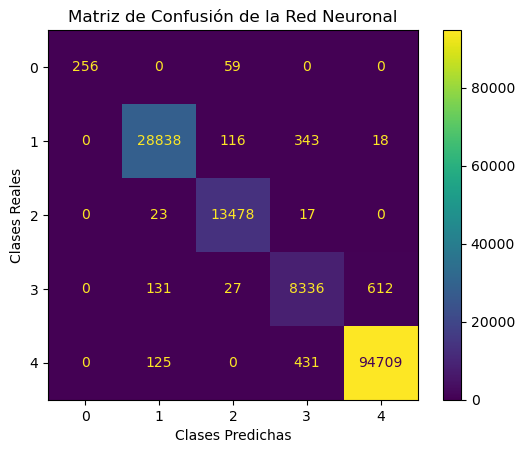

   Frecuencia  Porcentaje (%)
4       95339       64.628285
1       29117       19.737796
2       13680        9.273382
3        9127        6.187000
0         256        0.173537


In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Cargar el dataset con las clases reales y predichas
data = pd.read_csv('PPC_con_Clase_Predicha.csv')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(data['Clase'], data['Clase_Predicha'])

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(data['Clase'].unique()))
disp.plot(cmap='viridis', values_format='d')

# Personalizar el gráfico
plt.title("Matriz de Confusión de la Red Neuronal")
plt.xlabel("Clases Predichas")
plt.ylabel("Clases Reales")
plt.grid(False)
plt.show()

# Calcular frecuencias y porcentajes
frecuencias = data['Clase_Predicha'].value_counts()
porcentajes = data['Clase_Predicha'].value_counts(normalize=True) * 100

# Combinar ambos resultados en un DataFrame para mejor visualización
resumen = pd.DataFrame({
    'Frecuencia': frecuencias,
    'Porcentaje (%)': porcentajes
})

# Mostrar el resumen
print(resumen)
